### Импортируем библиотеки

In [1]:
!git clone https://github.com/snosachyev/yolov3.git

Клонирование в «yolov3»...
remote: Enumerating objects: 34, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 34 (delta 13), reused 32 (delta 11), pack-reused 0 (from 0)
Получение объектов: 100% (34/34), 4.26 МиБ | 2.78 МиБ/с, готово.
Определение изменений: 100% (13/13), готово.


In [2]:
import sys
sys.path.append('yolov3')

In [4]:
!cp yolov3/.env_template .env # once

In [3]:
# Обработка изображений
import cv2
import importlib
import os
import tensorflow as tf
# Линейная алгебра
import numpy as np
import pandas as pd
#numpy, pandas, cv2, tensorflow
# Графики
from matplotlib import pyplot as plt
from IPython.display import Image


# в режиме редактирования сбрасуем кэшь иначе не видно изменений
imported_module = importlib.import_module("settings")
importlib.reload(imported_module)
imported_module = importlib.import_module("utils")
importlib.reload(imported_module)
imported_module = importlib.import_module("model")
importlib.reload(imported_module)

import settings
import utils
from model import YoloV3, YoloLoss


from tensorflow.keras.callbacks import (
    ReduceLROnPlateau,
    EarlyStopping,
    ModelCheckpoint,
    TensorBoard
)

# Работаем с фреймворком Keras и Tensorflow
from tensorflow.python.client import device_lib


## Локальные настройки для gpu

In [14]:
# Настройка GPU до любых моделей/датасетов
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

tf.keras.backend.clear_session()

# Включаем смешанную точность (mixed precision)
from tensorflow.keras import mixed_precision

policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

print("Mixed precision policy:", mixed_precision.global_policy())
os.environ["XLA_FLAGS"] = "--xla_gpu_cuda_data_dir="

tf.config.optimizer.set_jit(False)
os.environ["TF_XLA_FLAGS"] = "--tf_xla_enable_xla_devices=false"

Mixed precision policy: <DTypePolicy "mixed_float16">


## Загрузка данных

In [ ]:
!wget https://storage.yandexcloud.net/academy.ai/CV/chess_yolo.zip
!unzip -qo "chess_yolo.zip"
!ls chess_yolo
!cat $settings.yaml_path

--2025-08-25 11:25:51--  https://storage.yandexcloud.net/academy.ai/CV/chess_yolo.zip
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 39275734 (37M) [application/x-zip-compressed]
Saving to: ‘chess_yolo.zip’

chess_yolo.zip      100%[===================>]  37.46M  11.9MB/s    in 4.8s    

2025-08-25 11:25:58 (7.86 MB/s) - ‘chess_yolo.zip’ saved [39275734/39275734]



## Подготавливаем датасет

In [16]:
img_train_dir, label_train_dir = "./chess_yolo/train/images", "./chess_yolo/train/labels"
train_ds = utils.build_dataset(img_train_dir, label_train_dir)

img_valid_dir, label_valid_dir = "./chess_yolo/valid/images", "./chess_yolo/valid/labels"
val_ds = utils.build_dataset(img_valid_dir, label_valid_dir)

I0000 00:00:1770972293.027474   12485 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2147 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Ti Laptop GPU, pci bus id: 0000:02:00.0, compute capability: 8.6


# Обучение и эксперименты

In [1]:
checkpoint = 'yolo3/checkpoints/yolov3_train_{epoch}.weights.h5'

### Полное обучение без finetuning

In [ ]:
checkpoint = 'yolo3/checkpoints/yolov3_train_{epoch}.weights.h5'

yolo = YoloV3(classes=settings.NUM_CLASSES, training=True)

# Loss для трёх голов
loss = [YoloLoss(settings.YOLO_ANCHORS[mask], classes=settings.NUM_CLASSES)
        for mask in settings.YOLO_ANCHOR_MASKS]

# Adam с начальным lr
initial_lr = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate=initial_lr)

yolo.compile(optimizer=optimizer, loss=loss, run_eagerly=True)

callbacks = [
    ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.5,        # уменьшение lr в 2 раза
        patience=2,        # после 2 эпох без улучшения
        verbose=1
    ),
    EarlyStopping(
        monitor='val_loss', 
        patience=5, 
        verbose=1, 
        restore_best_weights=True
    ),
    ModelCheckpoint(checkpoint, verbose=1, save_weights_only=True),
    TensorBoard(log_dir='logs')
]
history = yolo.fit(
    train_ds,
    validation_data=val_ds,
    epochs=settings.EPOCHS,
    callbacks=callbacks
)

### получаем веса coco в формате .h5

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


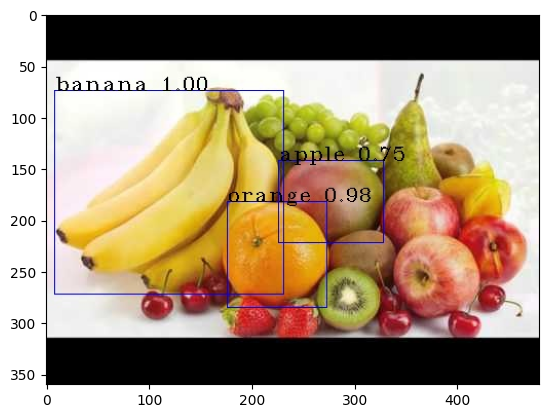

In [82]:
#WEIGHT_YOLO_V3 = 'yolov3.weights' # путь к файлу с предобученными весами
#yolo = YoloV3(classes=settings.NUM_CLASSES)
#utils.load_darknet_weights(yolo, WEIGHT_YOLO_V3)
#yolo.save_weights('coco.weights.h5')

# Задаем в white_list список искомых объектов
#utils.detect_objects(yolo, 'hqdefault.jpg', settings.CLASS_NAMES)

In [58]:
# меняем название полученных весов
#!cp coco.weights.h5 coco.h5
# или загружаем с диска если есть
#!cp /content/drive/MyDrive/yolo3/checkpoints/coco.h5 coco.h5

### fintuning

In [22]:
yolo = YoloV3(classes=settings.NUM_CLASSES, training=True)
# 2. Load pretrained coco
yolo.load_weights('coco.h5',
                   by_name=True,
                   skip_mismatch=True)
yolo.get_layer('yolo_darknet').trainable = False
# 5. Unfreeze all
for l in yolo.layers:
    l.trainable = True
    

# Если количество классов отличается от COCO:
# - Можно заменить последнюю голову
# - Или переопределить слои под новые классы

loss = [YoloLoss(settings.YOLO_ANCHORS[mask], classes=settings.NUM_CLASSES)
        for mask in settings.YOLO_ANCHOR_MASKS]

# Меньший lr для fine-tuning
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

yolo.compile(optimizer=optimizer, loss=loss, run_eagerly=True)

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1),
    EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True),
    ModelCheckpoint(checkpoint, verbose=1, save_weights_only=True),
    TensorBoard(log_dir='logs')
]

FEEZE_EPOCH = 10
history = yolo.fit(
    train_ds,
    validation_data=val_ds,
    epochs=FEEZE_EPOCH,
    callbacks=callbacks
)

Epoch 1/10


2026-02-13 11:46:49.920298: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91002


  1/606 ━━━━━━━━━━━━━━━━━━━━ 1:43:46 10s/step - loss: 10089.0557 - yolo_output_1_loss: 285.5074 - yolo_output_2_loss: 1787.1886 - yolo_output_3_loss: 8004.6387

2026-02-13 11:47:09.797854: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:501] Allocator (GPU_0_bfc) ran out of memory trying to allocate 18.00MiB (rounded to 18874368)requested by op Tile
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2026-02-13 11:47:09.798138: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1049] BFCAllocator dump for GPU_0_bfc
2026-02-13 11:47:09.798167: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1056] Bin (256): 	Total Chunks: 240, Chunks in use: 232. 60.0KiB allocated for chunks. 58.0KiB in use in bin. 20.3KiB client-requested in use in bin.
2026-02-13 11:47:09.798187: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1056] Bin (512): 	Total Chunks: 257, Chunks in use: 210. 131.2KiB allocated for chunks. 105.0KiB in use in bin. 105.0KiB client-requested in use in bin.
20

ResourceExhaustedError: {{function_node __wrapped__Tile_device_/job:localhost/replica:0/task:0/device:GPU:0}} OOM when allocating tensor with shape[3,3,512,1024] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Tile] name: 

### Выводим графики

In [ ]:
np.save('my_history.npy',history.history)

history=np.load('my_history.npy',allow_pickle='TRUE').item()

plt.figure(figsize=(10, 6)) # Optional: Adjust figure size
plt.plot(history['loss'])
plt.title('YOLOv3 Training Loss')
plt.xlabel('Epochs (or Iterations)')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [9]:
#from google.colab import drive
#drive.mount('/content/drive')
#!cp yolo3/checkpoints/yolov3_train_7.weights.h5 /content/drive/MyDrive
#!ls /content/drive/f=

## Эксперименты

In [90]:
yolo = YoloV3(classes=settings.NUM_CLASSES, training=False)

In [91]:
yolo.load_weights(checkpoint.format(epoch=1))

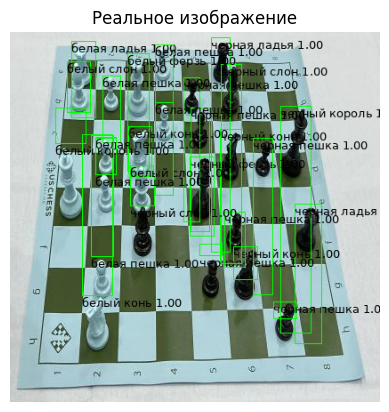

chess_yolo/test/images/fdcd6ada676799da8a870f58fdf548db_jpg.rf.b0ea8552b6106bb4ab62ca8957fca40d.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


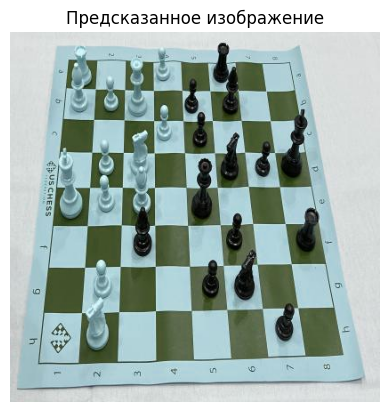

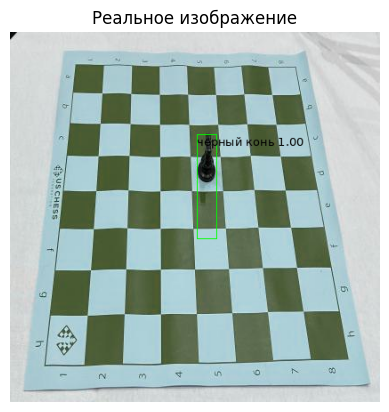

chess_yolo/test/images/654bb8835258b26c466b1c19893df451_jpg.rf.55fb7f23a4422a80793f01e152fabe4d.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


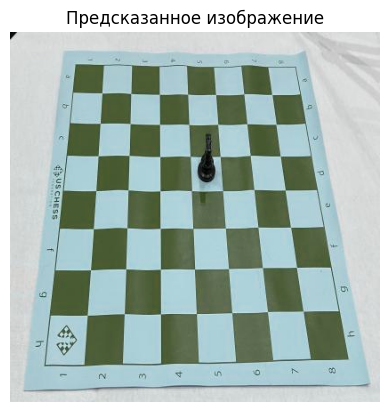

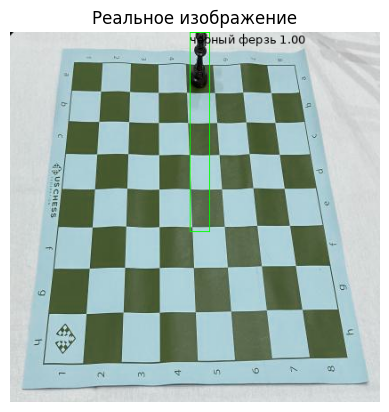

chess_yolo/test/images/4e3117459d759798537eb52cf5bf534d_jpg.rf.ec961b62d4b0e131fae760ed1f80836b.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step


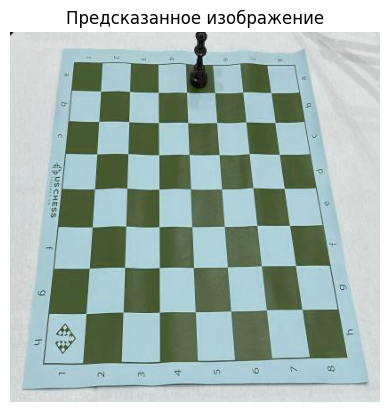

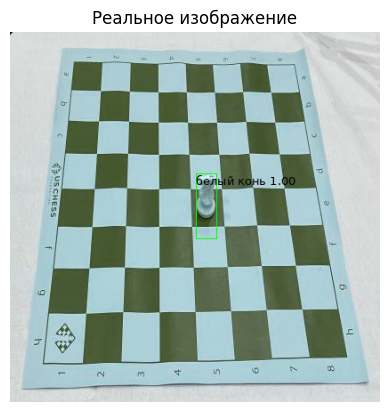

chess_yolo/test/images/5a35ba2ec3e0d0b2b12b1758a8ac29aa_jpg.rf.9dbdb057f6533c0c09c0eda0747fbc9e.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


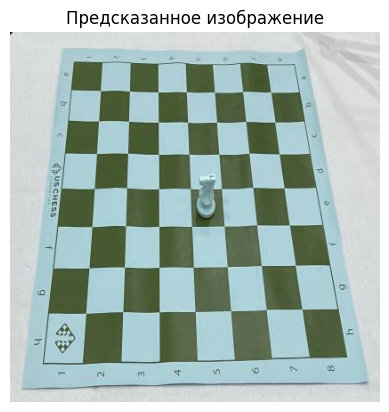

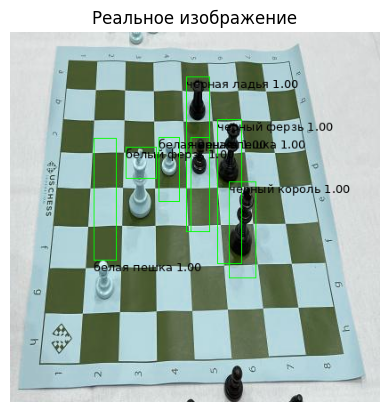

chess_yolo/test/images/685b860d412b91f5d4f7f9e643b84452_jpg.rf.2d78193e4021ae5ffb49ecd1060bebd7.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step


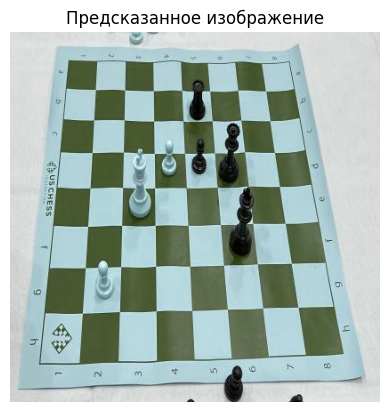

In [102]:
for _ in range(5):
    image_path, label = utils.get_random_image_label()
    class_names = list(settings.CLASS_NAMES.values())

    # Реальное изображение с размеченными метками
    real_image = utils.draw_yolo_labels(image_path, label, class_names)
    plt.title("Реальное изображение")
    plt.imshow(real_image)
    plt.axis("off")
    plt.show()

    # Загружаем в numpy для предсказания
    img_array = cv2.imread(image_path)
    img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)

    detected_img = utils.detect_objects(
        yolo,
        image_path,  # <-- путь к файлу
        settings.CLASS_NAMES
    )

    plt.title("Предсказанное изображение")
    plt.imshow(detected_img)
    plt.axis("off")
    plt.show()


### Вывод

Собрал датасет из имеющихся файлов, основная сложность кординаты не четыре точки а полиго, нужно конвертировать.
Очень сложная тема, информацию тянул с любых доступных мест, перчетал много статей, в том числе с помощью чат бота, веде было информация но прям под это задание не было, поэтому тольок эксперименты.
Вывел распознование из папки тест, и одно изображение перегнал в портретную ореинтацию тут так же видно чтоработает.
Попутно задание требовало большего погружения в тензорфлов, теяжело и плюс)
Еще сложность была понять как рапределить loss на три головы.

обучал с learning_rate=1e-5 сначала были бешенные потери, начиная с 2000 но с концу они стали в 10 раз меньше, далее уже запустил обучение на 10 эпох, но с этого момента потери стали падать все меньше и меньше.
Далее повысил шаг, хотя нужно было с начала выше сделать, а потом ниже, но все равно срабатывала остановка.